### VQSL EXAMPLE

In [ ]:
# CODE CREDITS: https://pennylane.ai/qml/demos/tutorial_vqls.html

*note*

things to possibly experiment with:
- different problem sizes
- differents etas
- different spreads of inital weights

### Overview of the Variational Quantum Linear Solver Algorithm
The problem of solving linear systems of equations is one that has an application in many fields, such as ML, and AI.

When the problem gets very large, its compute time gets very large as well, and doesn't scale efficiently. For this reason, we look to quantum computers to help us speed up the problem solving. 

Unfortunately, the originally proposed quantum algorithm used to solve this problem, called the HHL algorithm, cannot be effeciently implemented on today's NISQ hardware. For this reason, the **VQLS** algorithm is a promising candidate for solving linear systems problems in the near term.

Say we have a a linear solving problem that we hope to solve. This problem can be represented as a $2^N$ x $2^N$ matrix A, (where N is the problem size). This matrix can be expressed as a combination of $L$ unitary matricies. 

i.e. $A = A_1 + A_2 + ... + A_L$ 

The objective is to find a quantum solution state, $|x\rangle$, such that $A|x\rangle$ is proportional to vector $|b\rangle$

i.e.
$|\Psi\rangle := \cfrac{A|x\rangle}{\sqrt{\langle x|A^{\dagger} A|x\rangle}} \approx |b\rangle$

The steps that the VQLS algorithm takes to solve this problem as as follows:
1. Encode both the problem matrix $A$ and problem vector $|b\rangle$ (A is assumed to be a combination of Pauli operators $A = \sum_{l=1}^{L} c_l\sigma_l$)
2. Create a variational circuit / unitary circuit $V$ that depends on a finite number of classical real parameters $a=(a_0,a_1,…a_n)$ that prepared a potential solution, $|x\rangle = V(a)|0\rangle$
3. The parameters $a$ arinputted to a quantum computer, to prepare $|x(a)\rangle$ 
4. Run an efficient quantum circuit that estimates a cost function, $C(a)$
5. Optimize parameter $a$ in attempt to minimize $C(a)$
6. Repeat steps 2-5 until a convegence criteria is met.

The cost function is generally defined as:
$C = 1- |\langle\Psi|b\rangle|^2$,

where $|\langle\Psi|b\rangle|^2$ defines the overlap between the solution and vector problem.

One can either use a a global or a local cost function. Generally, the local cost function will provide results faster, whereas the global cost function will provide more accuracte solutions.

1. $\hat{C}_G = \langle x|H_G|x\rangle$,

where $\langle x|H_G|x\rangle =$ $A^{\dagger} (1=|b\rangle\langle b|)A$

2. $\hat{C}_L = \langle x|H_L|x\rangle$

where $\langle x|H_L|x\rangle = A^{\dagger}U(1 - \cfrac{1}{n}\sum\limits_{j=1}^n|0_j\rangle\langle0_j|\otimes 1_j)U^{\dagger}A $

In [15]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt
import math

In [134]:
n_qubits = 9  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 30  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator

In [135]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 0.2, 0.2, 0.2, 0.3, 0.5, 0.5 ])

def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])
    elif idx == 3:
        qml.CNOT(wires=[ancilla_idx, 1])
        qml.CZ(wires=[ancilla_idx, 2])
    
    elif idx == 4:
        qml.CNOT(wires=[ancilla_idx, 1])
    elif idx == 5:
        qml.CNOT(wires=[ancilla_idx, 2])
        qml.CZ(wires=[ancilla_idx, 4])
        
    elif idx == 6:
        qml.CNOT(wires=[ancilla_idx, 2])
    elif idx == 7:
        qml.CNOT(wires=[ancilla_idx, 3])
        qml.CZ(wires=[ancilla_idx, 7])



In [136]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

In [137]:
dev_mu = qml.device("default.qubit", wires=tot_qubits)

@qml.qnode(dev_mu)
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i" phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [138]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

In [139]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [140]:
def cost_loc(weights):
    """Local version of the cost function, which tends to zero when A |x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))


In [141]:
opt = qml.GradientDescentOptimizer(eta)

In [144]:
import time

np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits)

start = time.time()
cost_history = []
for it in range(steps):
    w = opt.step(cost_loc, w)
    cost = cost_loc(w)
    
    if it % 5 == 0:
        print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
        
    cost_history.append(cost)
end = time.time() - start

Step   0       Cost_L = 0.0080091
Step   5       Cost_L = 0.0061964
Step  10       Cost_L = 0.0047693
Step  15       Cost_L = 0.0036754
Step  20       Cost_L = 0.0028558
Step  25       Cost_L = 0.0022521


In [145]:
print('{:5f}'.format(end))

1442.179147


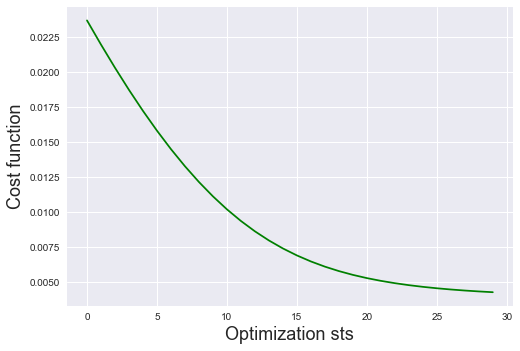

In [119]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function", fontsize=18)
plt.xlabel("Optimization sts", fontsize=18)
plt.show()

In [27]:
print(q_probs)

NameError: name 'q_probs' is not defined